# SELF-SUPERVISED DENOISING: PART THREE
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

[SIXIU] You need to write this for yourself - what is the purpose of this notebook

### Methodology Recap
In the previous notebooks we utilised blind-spots for the suppression of random noise. In tutorial two, we learnt that whilst there are some work-arounds to decrease the methodologies reliance on independent, random noise, the previous blind-spot procedures were not built for coherent noise suppression.

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

from unet import UNet
from tutorial_utils import weights_init, set_seed, add_trace_wise_noise, make_data_loader

In [2]:
cmap='seismic'
vmin = -0.5
vmax = 0.5

set_seed(42) # For reproducibility set random, numpy and torch seeds

True

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the data folder of the repository: https://github.com/swag-kaust/Transform2022_SelfSupervisedDenoising

In [3]:
d = np.load("./data/Hess_ShotGathers_ReducedSize.npy")
print(d.shape)

(404, 512, 256)


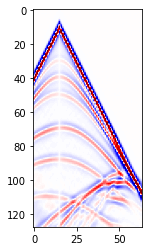

In [5]:
# Plot to see the noise free data
plt.imshow(d[80], cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

In [6]:
noisy_patches = add_trace_wise_noise(d,
                                     num_noisy_traces=5,
                                     noisy_trace_value=0.,
                                     num_realisations=7,
                                    )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

(2828, 128, 64)


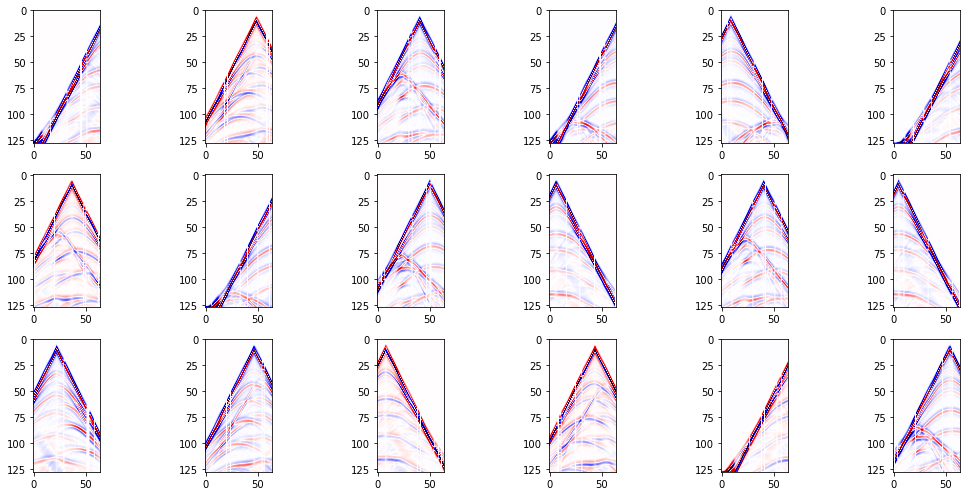

In [7]:
# plot to see the noisy data
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

# Step Two - Blindspot corruption of training data

In [8]:
# Create a function that randomly selects pixels and corrupts traces following StrucN2V methodology
def multi_active_pixels(patch, 
                        active_number,NoiseLevel,Maskwidth,metrice):

    # Select multiple locations for active pixels
    corr=[]                     
    for i in range( active_number*2):
        corr.append(np.random.randint(0,patch.shape[1],1))
    corr=np.array(corr).reshape([active_number,2])    
    
    
    # Make mask and Select metrice for calculating loss
    mask = np.ones_like(patch)
    if metrice=='active':
            mask[tuple(corr.T)] = 0    
    elif metrice=='trace':
            mask[:,tuple(corr.T)[1]] = 0
     
    
    # Make corrupted patch
    cp_ptch=patch.copy()    
    mix=corr
    for i in range(Maskwidth+1):
        mixcopy=mix.copy()
        mixcopy.T[1]=mix.T[1]-i
        mixcopy = mixcopy.clip(min=np.zeros(2),max=np.array(patch.shape)-1).astype(np.uint)
        cp_ptch[:,tuple( mixcopy.T)[1]] = np.random.rand(patch.shape[0],corr.shape[0])*NoiseLevel*2 - NoiseLevel
       
    for i in range(Maskwidth):
        mixcopy=mix.copy()
        mixcopy.T[1]=mix.T[1]+i+1
        mixcopy = mixcopy.clip(min=np.zeros(2),max=np.array(patch.shape)-1).astype(np.uint)
        cp_ptch[:,tuple( mixcopy.T)[1]] = np.random.rand(patch.shape[0],corr.shape[0])*NoiseLevel*2 - NoiseLevel
        
    return cp_ptch, mask

In [9]:
# Check the corruption function works
crpt_patch, mask = multi_active_pixels(noisy_patches[0], 
                                       active_number=3, 
                                       NoiseLevel=0.5,
                                       Maskwidth=0,
                                       metrice='trace')

Text(0.5, 1.0, 'Corruption Mask')

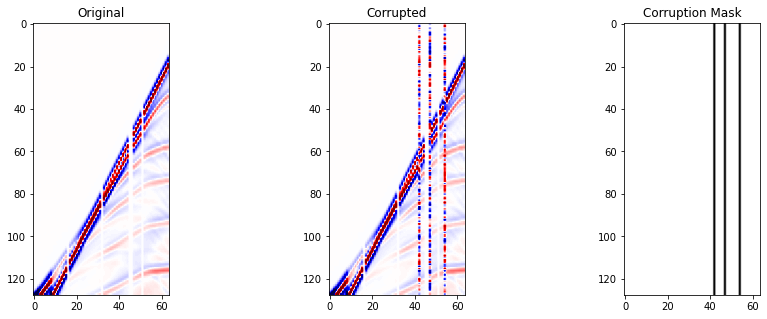

In [10]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(noisy_patches[0], cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(crpt_patch, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(mask, cmap='binary_r')

axs[0].set_title('Original')
axs[1].set_title('Corrupted')
axs[2].set_title('Corruption Mask')

***

# Step three - Set up network

In [11]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


In [12]:
# Build UNet
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
network = network.apply(weights_init) 


/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/tutorial_utils.py:117: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/tutorial_utils.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [13]:
# Network initialisation steps
n_epochs = 101
lr = 1e-4 
criterion = nn.L1Loss()
optim = torch.optim.Adam(network.parameters(), betas=(0.5, 0.999),lr=lr)

In [14]:
# Data training parameters
n_training = 2048
n_test = 256
batch_size = 32

***

# Step four - training

In [15]:
# Initial train and val 
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
val_loss_history = np.zeros(n_epochs)
val_accuracy_history = np.zeros(n_epochs)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

In [16]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        yprob = model(X)

        # TO DO: Compute loss function only at masked locations
        # (Hint: only one line required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        
        ls.backward()
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)   

    return loss, accuracy

In [17]:
# TRAINING
for ep in range(n_epochs):  
    
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               active_number=15, 
                                                               NoiseLevel=0.25,
                                                               Maskwidth=0,
                                                               metrice='trace')
        
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)

#     test_loss, test_accuracy, test_metrics = n2v_evaluate(network, 
#                                                            criterion,
#                                                            test_loader, 
#                                                            device,
#                                                             synth=False,
#                                                             plotflag=True if ep%5==0 else False)

    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy
#     test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy
    
    basedir = os.path.join("./newnet")
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    
    if ep%1==0: 
        mod_name ='denoise_ep%i.net'%ep
        torch.save(network, basedir+'/'+mod_name)
    

    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, ''')
#     Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')
    
    
    

100%|██████████| 64/64 [00:06<00:00,  9.69it/s]


Epoch 0, 
    Training Loss 0.0076,     Training Accuracy 0.0971, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 1, 
    Training Loss 0.0056,     Training Accuracy 0.0630, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 2, 
    Training Loss 0.0049,     Training Accuracy 0.0586, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 3, 
    Training Loss 0.0047,     Training Accuracy 0.0578, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 4, 
    Training Loss 0.0045,     Training Accuracy 0.0573, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 5, 
    Training Loss 0.0044,     Training Accuracy 0.0568, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 6, 
    Training Loss 0.0044,     Training Accuracy 0.0564, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 7, 
    Training Loss 0.0042,     Training Accuracy 0.0555, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 8, 
    Training Loss 0.0041,     Training Accuracy 0.0549, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 9, 
    Training Loss 0.0040,     Training Accuracy 0.0541, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 10, 
    Training Loss 0.0039,     Training Accuracy 0.0536, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 11, 
    Training Loss 0.0038,     Training Accuracy 0.0531, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 12, 
    Training Loss 0.0037,     Training Accuracy 0.0528, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 13, 
    Training Loss 0.0036,     Training Accuracy 0.0526, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 14, 
    Training Loss 0.0036,     Training Accuracy 0.0524, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 15, 
    Training Loss 0.0035,     Training Accuracy 0.0522, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 16, 
    Training Loss 0.0035,     Training Accuracy 0.0521, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 17, 
    Training Loss 0.0035,     Training Accuracy 0.0519, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 18, 
    Training Loss 0.0034,     Training Accuracy 0.0518, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 19, 
    Training Loss 0.0033,     Training Accuracy 0.0517, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 20, 
    Training Loss 0.0033,     Training Accuracy 0.0515, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 21, 
    Training Loss 0.0033,     Training Accuracy 0.0514, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 22, 
    Training Loss 0.0033,     Training Accuracy 0.0512, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 23, 
    Training Loss 0.0032,     Training Accuracy 0.0509, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 24, 
    Training Loss 0.0032,     Training Accuracy 0.0508, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 25, 
    Training Loss 0.0032,     Training Accuracy 0.0506, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 26, 
    Training Loss 0.0031,     Training Accuracy 0.0505, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 27, 
    Training Loss 0.0031,     Training Accuracy 0.0503, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 28, 
    Training Loss 0.0031,     Training Accuracy 0.0503, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 29, 
    Training Loss 0.0031,     Training Accuracy 0.0500, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 30, 
    Training Loss 0.0031,     Training Accuracy 0.0499, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 31, 
    Training Loss 0.0030,     Training Accuracy 0.0497, 


100%|██████████| 64/64 [00:06<00:00, 10.12it/s]


Epoch 32, 
    Training Loss 0.0030,     Training Accuracy 0.0496, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 33, 
    Training Loss 0.0030,     Training Accuracy 0.0494, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 34, 
    Training Loss 0.0029,     Training Accuracy 0.0491, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 35, 
    Training Loss 0.0029,     Training Accuracy 0.0492, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 36, 
    Training Loss 0.0029,     Training Accuracy 0.0490, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 37, 
    Training Loss 0.0029,     Training Accuracy 0.0488, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 38, 
    Training Loss 0.0029,     Training Accuracy 0.0486, 


100%|██████████| 64/64 [00:06<00:00, 10.07it/s]


Epoch 39, 
    Training Loss 0.0029,     Training Accuracy 0.0484, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 40, 
    Training Loss 0.0028,     Training Accuracy 0.0484, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 41, 
    Training Loss 0.0028,     Training Accuracy 0.0483, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 42, 
    Training Loss 0.0028,     Training Accuracy 0.0482, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 43, 
    Training Loss 0.0028,     Training Accuracy 0.0481, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 44, 
    Training Loss 0.0028,     Training Accuracy 0.0479, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 45, 
    Training Loss 0.0027,     Training Accuracy 0.0480, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 46, 
    Training Loss 0.0027,     Training Accuracy 0.0478, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 47, 
    Training Loss 0.0027,     Training Accuracy 0.0477, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 48, 
    Training Loss 0.0027,     Training Accuracy 0.0476, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 49, 
    Training Loss 0.0027,     Training Accuracy 0.0478, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 50, 
    Training Loss 0.0027,     Training Accuracy 0.0475, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 51, 
    Training Loss 0.0027,     Training Accuracy 0.0476, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 52, 
    Training Loss 0.0026,     Training Accuracy 0.0474, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 53, 
    Training Loss 0.0026,     Training Accuracy 0.0473, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 54, 
    Training Loss 0.0026,     Training Accuracy 0.0472, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 55, 
    Training Loss 0.0026,     Training Accuracy 0.0471, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 56, 
    Training Loss 0.0026,     Training Accuracy 0.0471, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 57, 
    Training Loss 0.0026,     Training Accuracy 0.0470, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 58, 
    Training Loss 0.0026,     Training Accuracy 0.0470, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 59, 
    Training Loss 0.0026,     Training Accuracy 0.0471, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 60, 
    Training Loss 0.0025,     Training Accuracy 0.0469, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 61, 
    Training Loss 0.0025,     Training Accuracy 0.0469, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 62, 
    Training Loss 0.0025,     Training Accuracy 0.0468, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 63, 
    Training Loss 0.0025,     Training Accuracy 0.0468, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 64, 
    Training Loss 0.0025,     Training Accuracy 0.0468, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 65, 
    Training Loss 0.0025,     Training Accuracy 0.0467, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 66, 
    Training Loss 0.0025,     Training Accuracy 0.0468, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 67, 
    Training Loss 0.0025,     Training Accuracy 0.0467, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 68, 
    Training Loss 0.0025,     Training Accuracy 0.0466, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 69, 
    Training Loss 0.0025,     Training Accuracy 0.0467, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 70, 
    Training Loss 0.0025,     Training Accuracy 0.0466, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 71, 
    Training Loss 0.0025,     Training Accuracy 0.0466, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 72, 
    Training Loss 0.0024,     Training Accuracy 0.0466, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 73, 
    Training Loss 0.0024,     Training Accuracy 0.0466, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 74, 
    Training Loss 0.0024,     Training Accuracy 0.0466, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 75, 
    Training Loss 0.0024,     Training Accuracy 0.0465, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 76, 
    Training Loss 0.0024,     Training Accuracy 0.0466, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 77, 
    Training Loss 0.0024,     Training Accuracy 0.0465, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 78, 
    Training Loss 0.0024,     Training Accuracy 0.0465, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 79, 
    Training Loss 0.0024,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 80, 
    Training Loss 0.0024,     Training Accuracy 0.0464, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 81, 
    Training Loss 0.0024,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 82, 
    Training Loss 0.0023,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 83, 
    Training Loss 0.0023,     Training Accuracy 0.0464, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 84, 
    Training Loss 0.0023,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 85, 
    Training Loss 0.0023,     Training Accuracy 0.0464, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 86, 
    Training Loss 0.0023,     Training Accuracy 0.0464, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 87, 
    Training Loss 0.0023,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 88, 
    Training Loss 0.0023,     Training Accuracy 0.0464, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 89, 
    Training Loss 0.0023,     Training Accuracy 0.0464, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 90, 
    Training Loss 0.0023,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 91, 
    Training Loss 0.0023,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.11it/s]


Epoch 92, 
    Training Loss 0.0023,     Training Accuracy 0.0462, 


100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


Epoch 93, 
    Training Loss 0.0023,     Training Accuracy 0.0462, 


100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


Epoch 94, 
    Training Loss 0.0023,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:06<00:00, 10.08it/s]


Epoch 95, 
    Training Loss 0.0023,     Training Accuracy 0.0463, 


100%|██████████| 64/64 [00:10<00:00,  6.33it/s]


Epoch 96, 
    Training Loss 0.0022,     Training Accuracy 0.0462, 


100%|██████████| 64/64 [00:11<00:00,  5.75it/s]


Epoch 97, 
    Training Loss 0.0022,     Training Accuracy 0.0462, 


100%|██████████| 64/64 [00:11<00:00,  5.54it/s]


Epoch 98, 
    Training Loss 0.0022,     Training Accuracy 0.0462, 


100%|██████████| 64/64 [00:11<00:00,  5.59it/s]


Epoch 99, 
    Training Loss 0.0022,     Training Accuracy 0.0464, 


100%|██████████| 64/64 [00:06<00:00,  9.47it/s]

Epoch 100, 
    Training Loss 0.0022,     Training Accuracy 0.0464, 


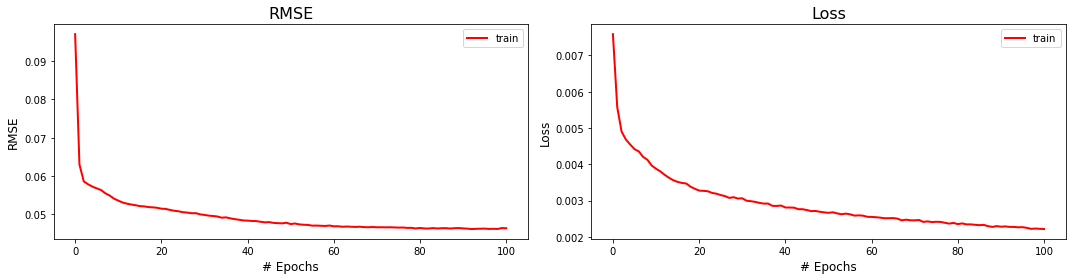

In [18]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(train_accuracy_history, 'r', lw=2, label='train')
# axs[0].plot(test_accuracy_history, 'k', lw=2, label='validation')
axs[0].set_title('RMSE', size=16)
axs[0].set_ylabel('RMSE', size=12)

axs[1].plot(train_loss_history, 'r', lw=2, label='train')
# axs[1].plot(test_loss_history, 'k', lw=2, label='validation')
axs[1].set_title('Loss', size=16)
axs[1].set_ylabel('Loss', size=12)


for ax in axs:
    ax.legend()
    ax.set_xlabel('# Epochs', size=12)
fig.tight_layout()

***

## Step five - apply trained model

In [19]:
d.shape

(404, 128, 64)

In [20]:
# Make a new noisy realisation so it's different from the training set
testdata = add_trace_wise_noise(d, 
                                num_noisy_traces=5,
                                noisy_trace_value=0.,
                                num_realisations=1)[80]

testdata.shape

(404, 128, 64)


(128, 64)

/tmp/ipykernel_122246/3606594558.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(1,4,figsize=[15,4])


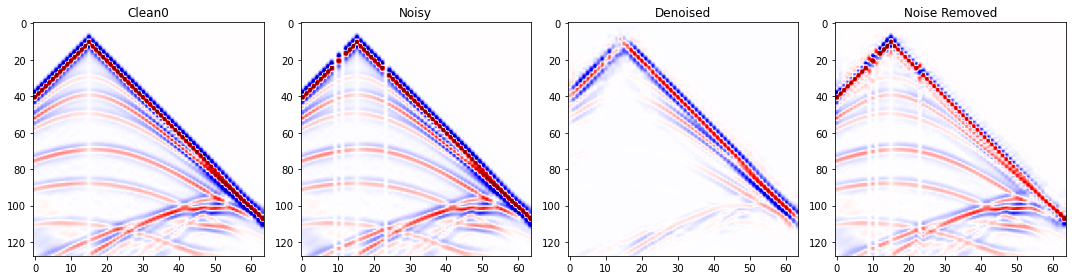

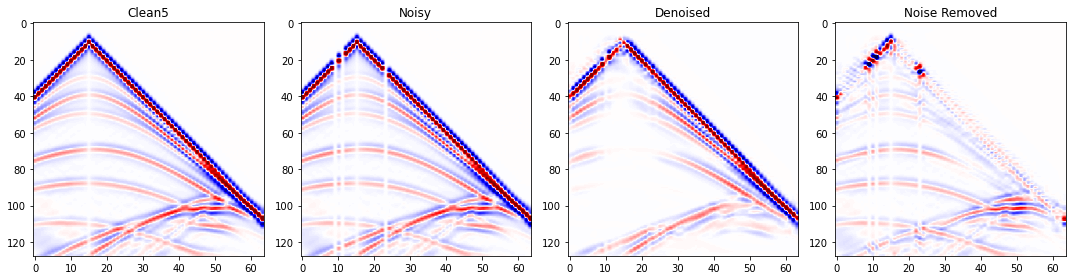

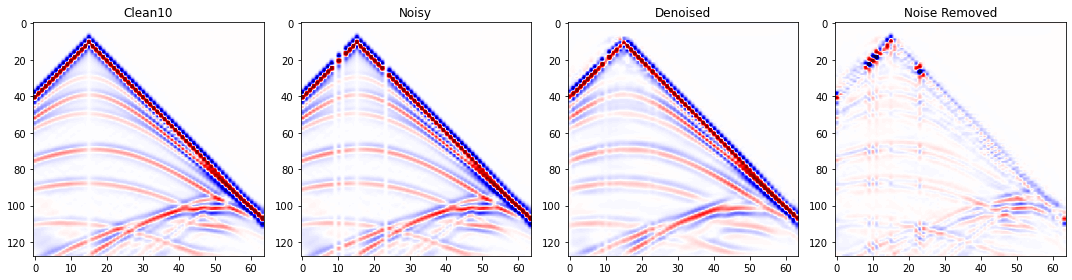

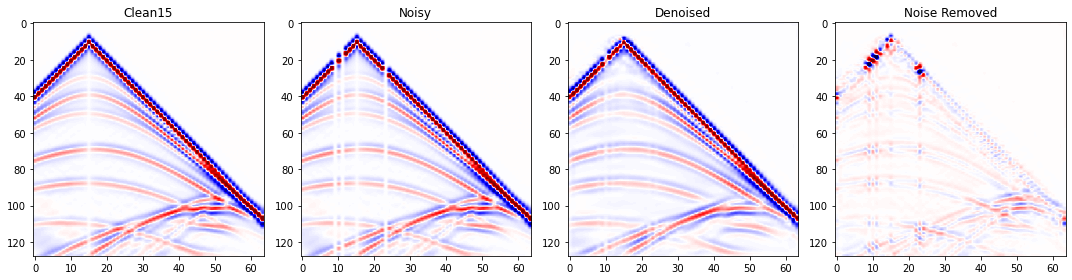

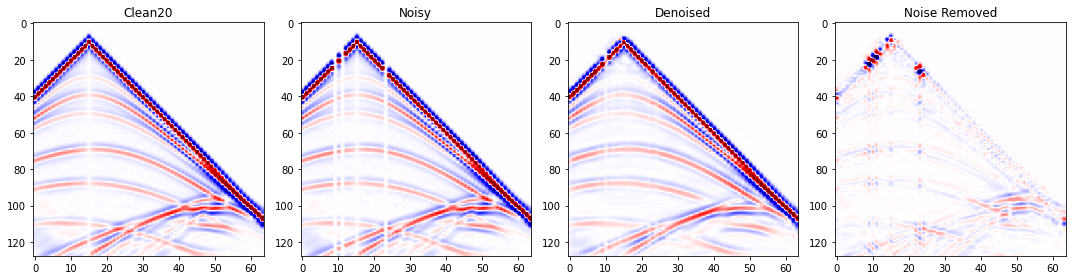

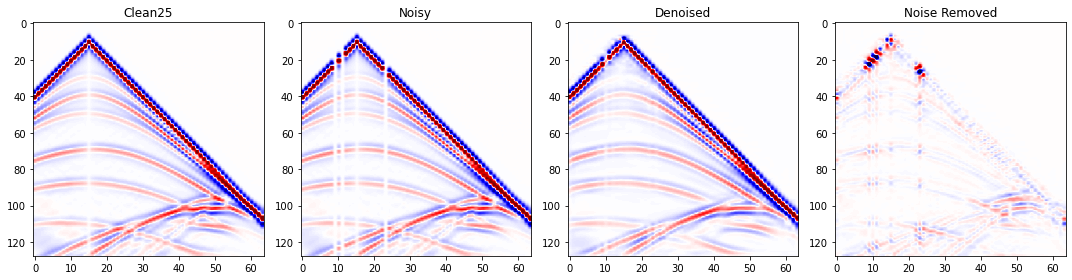

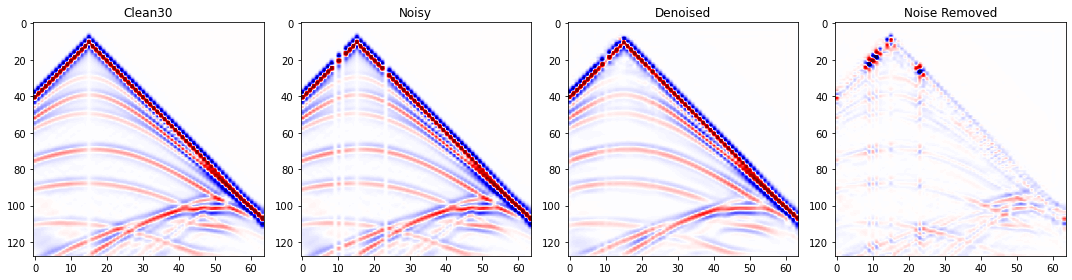

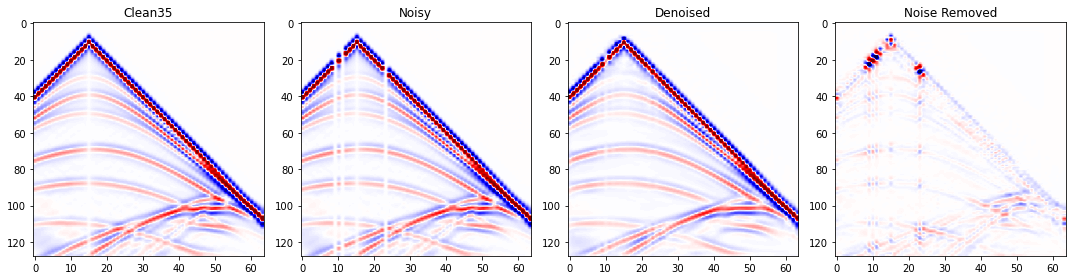

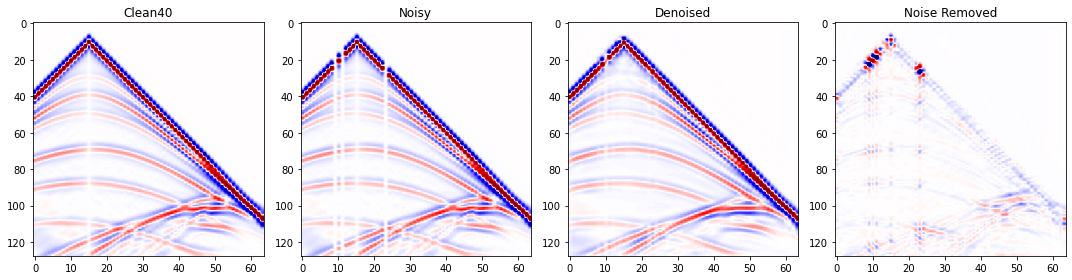

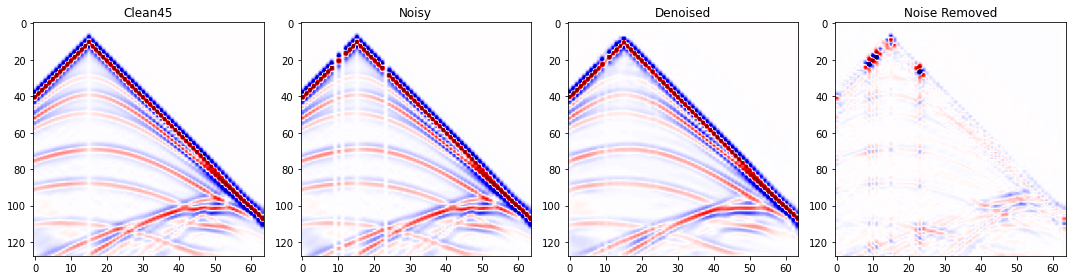

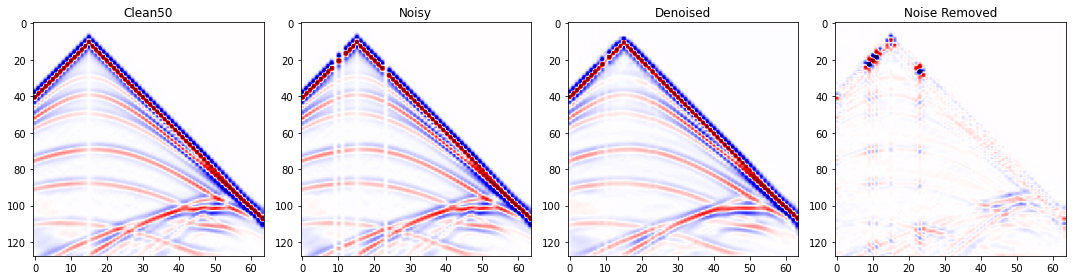

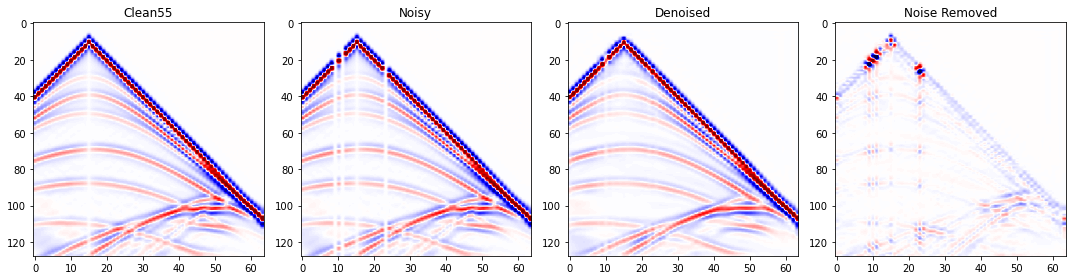

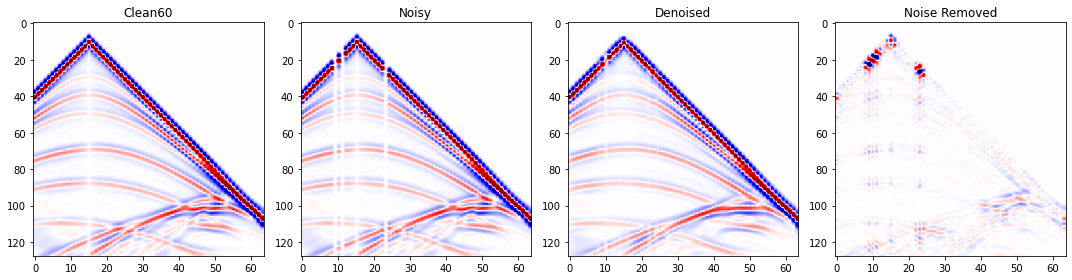

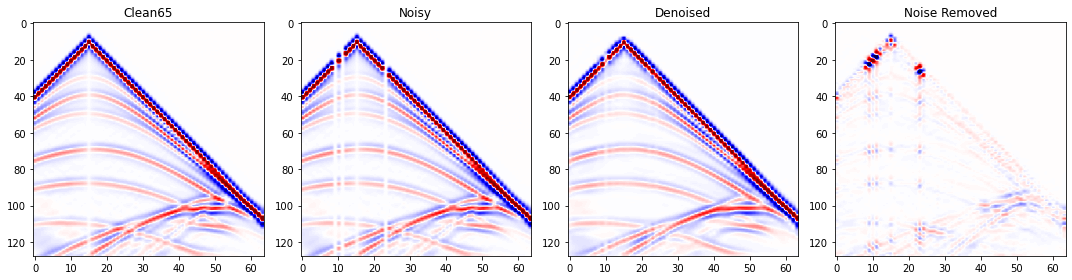

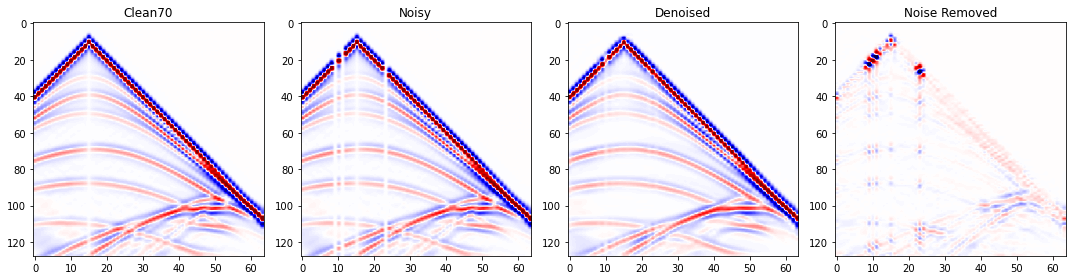

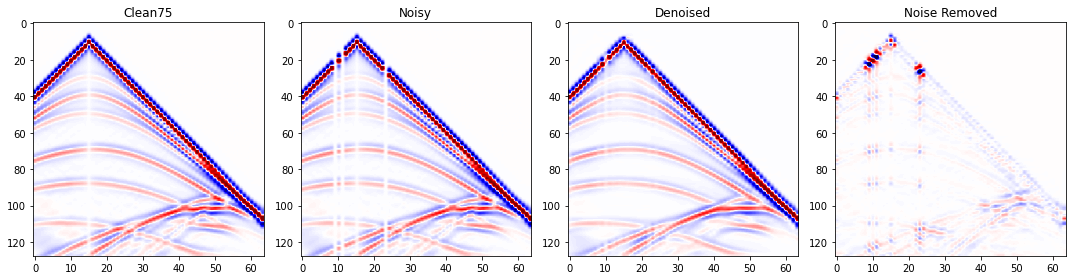

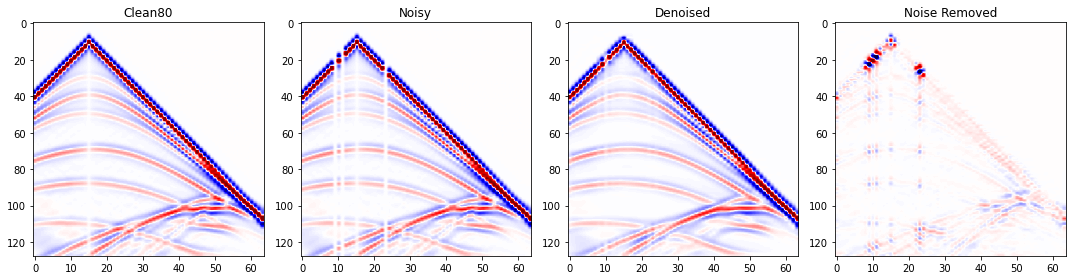

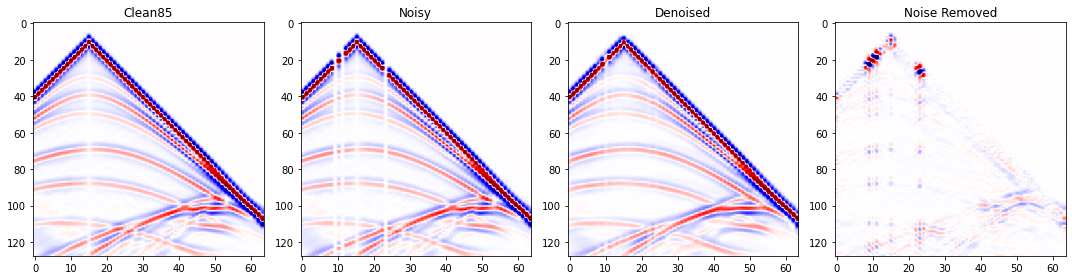

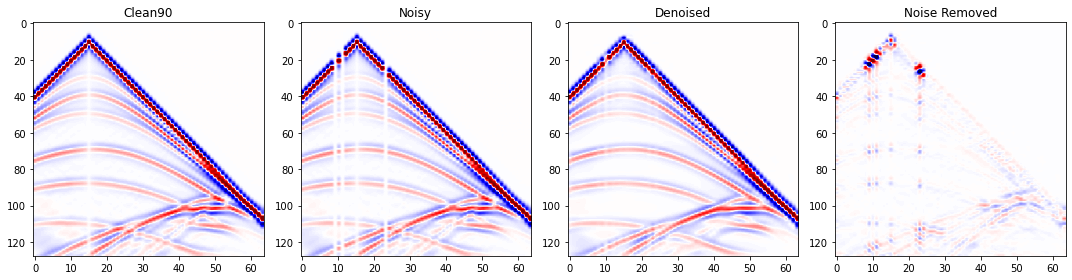

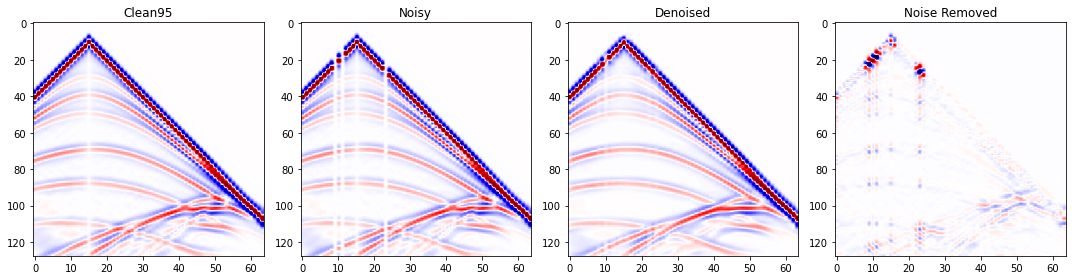

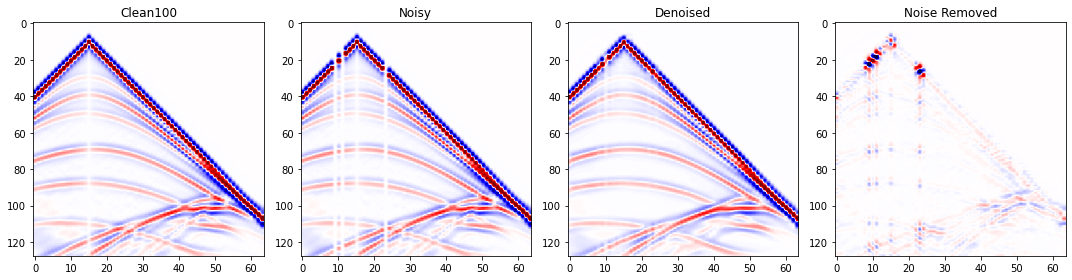

In [21]:
for ep in np.arange(n_epochs+1, step=5):
    
#     netG = UNet(1, 1, 32, 'bnorm').to(device)
#     init_net(netG, init_type='normal', init_gain=0.02, gpu_ids=0)
    netG = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=3).to(device)
    netG=torch.load('./newnet/denoise_ep'+str(ep)+'.net')
    
    torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()
    test_prediction = netG(torch_testdata.to(device))
    test_pred = test_prediction.detach().cpu().numpy().squeeze()
    
    fig,axs = plt.subplots(1,4,figsize=[15,4])
    axs[0].imshow(d[80], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].imshow(testdata, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[2].imshow(test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[3].imshow(testdata-test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    axs[0].set_title('Clean'+str(ep))
    axs[1].set_title('Noisy')
    axs[2].set_title('Denoised')
    axs[3].set_title('Noise Removed')

    fig.tight_layout()